# Legal Clause Semantic Search and Similarity Engine

## Dataset Introduction

This project uses the **CUAD (Contract Understanding Atticus Dataset)**, a large-scale, expert-annotated dataset for legal contract clause classification. CUAD was developed to help train models that can automatically identify and classify important legal clauses in contracts. It contains thousands of manually annotated legal clauses across hundreds of real-world contracts.

- **Dataset name**: CUAD (v1.0)
- **Source**: [Atticus Project](https://www.atticusprojectai.org/cuad)
- **Format**: JSON
- **Total clauses**: ~13,000+
- **Clause types**: 41 predefined legal clause categories

This project aims to explore, preprocess, and build a **semantic similarity and search engine** for legal clauses using modern sentence embedding models.

> **Dataset Path**: `dataset/CUAD_v1/CUAD_v1.json`

---

## Objectives of This Notebook

- Load and verify the dataset structure.
- Understand the nested schema (contracts → paragraphs → annotations).
- Extract all annotated clauses into a structured format.
- Store extracted data in a pandas DataFrame for downstream processing.



## Step 1: Load CUAD Dataset (v1.0)

We begin by loading the CUAD dataset from the local project directory. The dataset is provided as a nested JSON file containing two top-level keys:

- `"version"`: Dataset version
- `"data"`: A list of contracts, each with paragraphs and annotated clauses

We'll read the JSON file using Python's `json` module and verify its structure.


In [1]:
from pathlib import Path
import json

# — Assumes this notebook lives in <project_root>/notebooks/ —
BASE_DIR    = Path.cwd().parent
DATASET_PATH = BASE_DIR / "dataset" / "CUAD_v1" / "CUAD_v1.json"

# Fail fast if missing
if not DATASET_PATH.exists():
    raise FileNotFoundError(f"CUAD dataset not found at {DATASET_PATH.resolve()}")

# Load JSON
with open(DATASET_PATH, "r", encoding="utf-8") as f:
    cuad_json = json.load(f)

print(f"Located dataset at: {DATASET_PATH.resolve()}")
print(f"Top-level keys: {list(cuad_json.keys())}")

# Load contracts (will be a list)
contracts = cuad_json.get("data", [])
print(f"Total contracts loaded: {len(contracts)}")

Located dataset at: C:\Users\bestb\Desktop\MODELS\legal-clause-similarity-search\dataset\CUAD_v1\CUAD_v1.json
Top-level keys: ['version', 'data']
Total contracts loaded: 510


## Step 2: Inspect Contract Structure

Each contract in the `"data"` list contains:
- `"title"`: The name of the contract.
- `"paragraphs"`: A list of paragraphs in the contract.

Each paragraph has:
- `"paragraph"`: The raw clause text (string).
- `"annotations"`: A list of zero or more annotations (each with a clause label).

Only paragraphs that contain annotations are useful for clause classification and semantic analysis. Our goal is to extract those annotated paragraphs and associate them with their clause labels.


In [2]:
# — Sanity-check on `contracts` before inspecting —
if not isinstance(contracts, list):
    raise TypeError(f"Expected `contracts` to be a list, got {type(contracts)}")

if not contracts:
    raise ValueError(
        "CUAD JSON loaded, but `contracts` list is empty. "
        "Check that `cuad_json.get('data')` is correct and that the file isn’t empty."
    )

# Filter out any non-dict entries
contracts = [c for c in contracts if isinstance(c, dict)]
if not contracts:
    raise ValueError(
        "After filtering, no dict-typed contracts remain. "
        "Your JSON may be wrapped differently."
    )

# Show a sample contract for manual inspection
sample_contract = contracts[0]
print("Sample contract keys:", list(sample_contract.keys()))
print("Contract title:", sample_contract.get("title", "<no title key>"))
print("Paragraphs count:", len(sample_contract.get("paragraphs", [])))

# Inspect one sample paragraph
sample_paragraph = sample_contract.get("paragraphs", [])[0]
print("\nParagraph keys:", list(sample_paragraph.keys()))

# Preview paragraph text and annotations (if any)
print("\nParagraph Text:\n", sample_paragraph.get("paragraph", ""))

annotations = sample_paragraph.get("annotations", [])
print(f"\nNumber of annotations in this paragraph: {len(annotations)}")
if annotations:
    print("First annotation example:")
    print(annotations[0])


Sample contract keys: ['title', 'paragraphs']
Contract title: LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT
Paragraphs count: 1

Paragraph keys: ['qas', 'context']

Paragraph Text:
 

Number of annotations in this paragraph: 0


## Step 3: Extract Annotated Clauses from SQuAD-Style Format

In the CUAD v1 dataset, each contract consists of paragraphs structured in a QA (question-answer) format. Each paragraph has:
- `context`: The full paragraph or clause text.
- `qas`: A list of legal clause types (as questions), each with:
  - `question`: The clause type name (e.g., "Is there a confidentiality clause?")
  - `answers`: List of one or more answer spans (start + text)
  - `is_impossible`: A boolean indicating if the clause type is absent in this paragraph.

To extract labeled clauses:
- We loop through all contracts and their paragraphs.
- For each QA, we collect entries where `is_impossible == False`.
- Each valid entry gives us:
  - The paragraph text (`context`)
  - The clause type (`question`)
  - The answer span(s) indicating where the clause appears

We'll store each valid clause as a `(clause_text, clause_type)` pair for future use in semantic search and embedding.


In [3]:
def extract_clauses(contracts):
    """
    Extracts (text, type, context) for every non-impossible QA answer in each contract.
    Assumes `contracts` is a list of dicts with optional "paragraphs"→list.
    """
    clauses = []
    for contract in contracts:
        for paragraph in contract.get("paragraphs", []):
            context = paragraph.get("context", "").strip()
            for qa in paragraph.get("qas", []):
                # Only include possible questions
                if not qa.get("is_impossible", True):
                    clause_type = qa.get("question", "").strip()
                    for answer in qa.get("answers", []):
                        clause_text = answer.get("text", "").strip()
                        if clause_text:
                            clauses.append({
                                "clause_text": clause_text,
                                "clause_type": clause_type,
                                "context": context
                            })
    return clauses

# Replace the inline loops with a call to the new function
clause_data = extract_clauses(contracts)
print(f"Total extracted clauses with labels: {len(clause_data)}")


Total extracted clauses with labels: 13823


## Step 4: Convert Extracted Clauses to a DataFrame

With over 13,000 annotated legal clauses extracted, we now convert this data into a structured format for analysis.

Each row of the DataFrame will contain:
- `clause_text`: The span of text identified as a clause.
- `clause_type`: The legal category or class of the clause.
- `context`: The full paragraph from which the clause was extracted (for potential use in context-aware models or evaluation).

This structured format makes it easier to:
- Analyze clause distribution
- Visualize clause categories
- Prepare embeddings or search indexes


In [4]:
import pandas as pd
from IPython.display import display

# Build DataFrame from extracted clauses
df_clauses = pd.DataFrame(clause_data)
print(f"Extracted {len(df_clauses)} clauses.")

# 1) Check for empty DataFrame
if df_clauses.empty:
    raise ValueError(
        "No clauses were extracted—`clause_data` is empty. "
        "Verify that `extract_clauses()` is pulling from the correct keys."
    )

# 2) Validate schema
required_cols = {"clause_text", "clause_type", "context"}
missing = required_cols - set(df_clauses.columns)
if missing:
    raise ValueError(f"DataFrame is missing expected columns: {missing}")

# 3) Preview the first few rows
display(df_clauses.head())

# 4) (Optional) create a sample view for sanity
print("Sample clause_text:", df_clauses["clause_text"].iloc[0])


Extracted 13823 clauses.


,clause_text,clause_type,context
0,DISTRIBUTOR AGREEMENT,Highlight the parts (if any) of this contract ...,EXHIBIT 10.6\n\n ...
1,Distributor,Highlight the parts (if any) of this contract ...,EXHIBIT 10.6\n\n ...
2,Electric City Corp.,Highlight the parts (if any) of this contract ...,EXHIBIT 10.6\n\n ...
3,Electric City of Illinois L.L.C.,Highlight the parts (if any) of this contract ...,EXHIBIT 10.6\n\n ...
4,Company,Highlight the parts (if any) of this contract ...,EXHIBIT 10.6\n\n ...


Sample clause_text: DISTRIBUTOR AGREEMENT


## Step 5 – Clause Type Cleaning and Distribution Analysis

After cleaning the extracted clause data, we now visualize the clause type distribution. Legal clause categories tend to have verbose descriptions, so we will truncate labels for better readability in the plot.

This analysis helps:
- Verify the distribution of clause types
- Detect imbalances or dominant categories
- Prepare for class weighting or sampling if needed during modeling



Duplicate rows: 14

Missing values per column:


,count
clause_text,0
clause_type,0
context,0



Unique clause types: 41

Top 10 clause types (raw):


,frequency
clause_type,
"Highlight the parts (if any) of this contract related to ""Parties"" that should be reviewed by a lawyer. Details: The two or more parties who signed the contract",2550
"Highlight the parts (if any) of this contract related to ""License Grant"" that should be reviewed by a lawyer. Details: Does the contract contain a license granted by one party to its counterparty?",777
"Highlight the parts (if any) of this contract related to ""Cap On Liability"" that should be reviewed by a lawyer. Details: Does the contract include a cap on liability upon the breach of a party’s obligation? This includes time limitation for the counterparty to bring claims or maximum amount for recovery.",672
"Highlight the parts (if any) of this contract related to ""Anti-Assignment"" that should be reviewed by a lawyer. Details: Is consent or notice required of a party if the contract is assigned to a third party?",654
"Highlight the parts (if any) of this contract related to ""Audit Rights"" that should be reviewed by a lawyer. Details: Does a party have the right to audit the books, records, or physical locations of the counterparty to ensure compliance with the contract?",643
"Highlight the parts (if any) of this contract related to ""Insurance"" that should be reviewed by a lawyer. Details: Is there a requirement for insurance that must be maintained by one party for the benefit of the counterparty?",560
"Highlight the parts (if any) of this contract related to ""Document Name"" that should be reviewed by a lawyer. Details: The name of the contract",520
"Highlight the parts (if any) of this contract related to ""Agreement Date"" that should be reviewed by a lawyer. Details: The date of the contract",475
"Highlight the parts (if any) of this contract related to ""Expiration Date"" that should be reviewed by a lawyer. Details: On what date will the contract's initial term expire?",466



Top 10 clause types (cleaned):


,frequency
cleaned_type,
parties,2550
license grant,777
cap on liability,672
anti-assignment,654
audit rights,643
insurance,560
document name,520
agreement date,475
expiration date,466


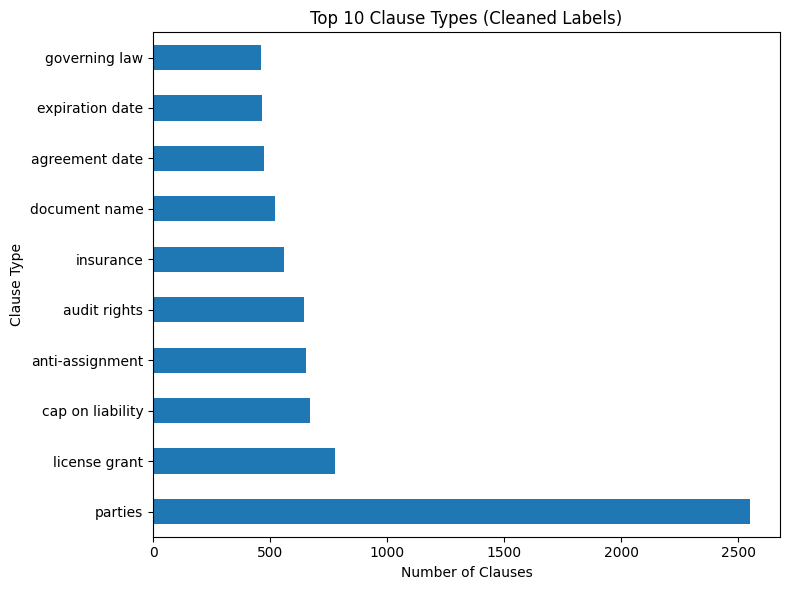

In [5]:
import matplotlib.pyplot as plt
from IPython.display import display

# Step 5: Clause Type Cleaning and Distribution Analysis

# 1) Deduplicate
duplicate_count = df_clauses.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")
df_clauses = df_clauses.drop_duplicates()

# 2) Check for missing values
missing_summary = df_clauses.isnull().sum()
print("\nMissing values per column:")
display(missing_summary.to_frame(name="count"))

# 3) Unique label count
unique_labels = df_clauses['clause_type'].nunique()
print(f"\nUnique clause types: {unique_labels}")

# 4) Top 10 raw clause types
print("\nTop 10 clause types (raw):")
display(df_clauses['clause_type'].value_counts().head(10).to_frame(name="frequency"))

# 5) Clean verbose labels for readability
df_clauses['cleaned_type'] = (
    df_clauses['clause_type']
      .str.replace(r'^Highlight the parts \(if any\) of this contract related to ', '', regex=True)
      .str.replace(r' that should be reviewed by a lawyer.*$', '', regex=True)
      .str.strip()
)

# 5.1) Normalize for downstream evaluation (removes quotes and trims spaces)
df_clauses['clause_type'] = df_clauses['clause_type'].str.strip().str.replace('"', '')
df_clauses['cleaned_type'] = df_clauses['cleaned_type'].str.strip().str.replace('"', '')
df_clauses['clause_type'] = df_clauses['clause_type'].str.lower()
df_clauses['cleaned_type'] = df_clauses['cleaned_type'].str.lower()


# 6) Top 10 cleaned labels
label_counts_cleaned = df_clauses['cleaned_type'].value_counts()
print("\nTop 10 clause types (cleaned):")
display(label_counts_cleaned.head(10).to_frame(name="frequency"))

# 7) Plot horizontal bar chart of top 10 cleaned labels
top10 = label_counts_cleaned.head(10)
plt.figure(figsize=(8, 6))
top10.plot(kind='barh')
plt.title("Top 10 Clause Types (Cleaned Labels)")
plt.xlabel("Number of Clauses")
plt.ylabel("Clause Type")
plt.tight_layout()
plt.show()


### Step 6: Normalize Clause Text for Consistent Embedding

Before feeding legal clauses into sentence embedding models for semantic search or classification, it's important to ensure that the clause text is clean and standardized. In this step, we normalize the clause text by:

- Converting all text to lowercase
- Removing leading/trailing whitespace
- Replacing non-breaking spaces and redundant whitespace
- Standardizing quotation marks and dashes (optional, to handle unicode inconsistencies)

This step ensures that downstream embedding models receive consistent input format.


In [ ]:
import re
from pathlib import Path

# — Step 6: Normalize Clause Text for Consistent Embedding —
def normalize_clause_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase & collapse spaces
    text = text.lower().replace("\xa0", " ")
    text = re.sub(r"\s+", " ", text).strip()
    # Normalize quotes/dashes
    text = text.replace("“", '"').replace("”", '"')
    text = text.replace("–", "-").replace("—", "-")
    return text

# Apply normalization
df_clauses["clause_text"] = df_clauses["clause_text"].apply(normalize_clause_text)

# Sanity check
print("Sample normalized clause text:\n")
print(df_clauses["clause_text"].iloc[0])

# — Save the normalized DataFrame —
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

NORMALIZED_PATH = RESULTS_DIR / "cuad_normalized_clauses.csv"
df_clauses.to_csv(NORMALIZED_PATH, index=False, encoding="utf-8")
print(f"Saved normalized clause data to: {NORMALIZED_PATH.resolve()}")


Sample normalized clause text:

distributor agreement
Saved normalized clause data to: C:\Users\bestb\Desktop\MODELS\legal-clause-similarity-search\results\cuad_normalized_clauses.csv


: 